In [6]:
# Install kagglehub
!pip install kagglehub

# Import required libraries
import kagglehub
import pandas as pd


In [7]:

# Download the dataset
path = kagglehub.dataset_download("prakashsahoo2/e-waste-product-expiry-and-price-prediction-dataset")


In [8]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/prakashsahoo2/e-waste-product-expiry-and-price-prediction-dataset/versions/1


In [9]:
# Load the CSV file
df = pd.read_csv(f"{path}/expiry_price_data.csv")

# Display first 5 rows
print("\nFirst 5 records:")
print(df.head())

# Display dataset info
print("\nDataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nDataset info:")
print(df.info())


First 5 records:
  Product_Type    Brand  Build_Quality  User_Lifespan Usage_Pattern  \
0       Laptop       HP              1            6.9      Moderate   
1   Smartphone  OnePlus              5            3.9      Moderate   
2       Laptop   Lenovo              3            6.1      Moderate   
3           TV  OnePlus              5           13.7         Heavy   
4  DSLR Camera     Sony              2            9.7      Moderate   

   Expiry_Years  Condition  Original_Price  Used_Duration  Current_Price  
0           7.0          3          118741             12         500.00  
1           4.8          5           73040              4       12173.33  
2           6.6          1           83604              5        8107.05  
3          14.4          2          120656              1       61752.41  
4          10.0          2           83435              6       21359.36  

Dataset shape: (15000, 10)

Column names:
['Product_Type', 'Brand', 'Build_Quality', 'User_Lifespan', 'U

In [11]:
# Install required libraries
!pip install xgboost lightgbm catboost scikit-learn

  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

[0]	validation_0-rmse:19663.99290
[100]	validation_0-rmse:1129.84899
[200]	validation_0-rmse:945.42138
[300]	validation_0-rmse:913.65896
[400]	validation_0-rmse:899.66063
[500]	validation_0-rmse:890.83314
[600]	validation_0-rmse:886.04845
[700]	validation_0-rmse:882.70237
[800]	validation_0-rmse:880.47766
[900]	validation_0-rmse:879.14717
[999]	validation_0-rmse:877.67618

=== XGBoost Results ===
MAE: 383.58
RMSE: 877.68
R² Score: 0.9982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] Start training from score 13097.240762
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 1.67465e+06
[LightGBM] [Warning] No further splits with positive ga

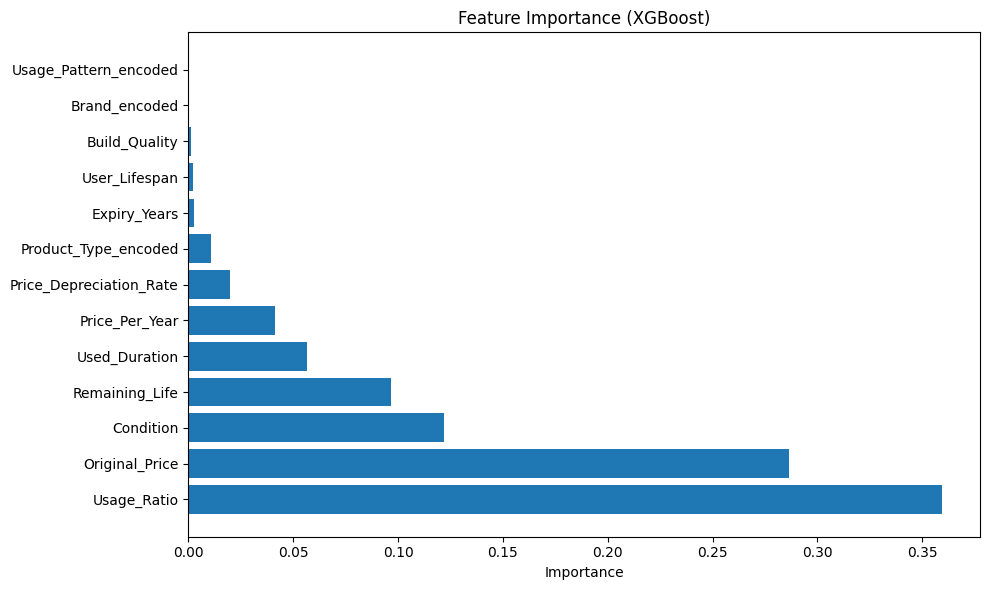

In [13]:
# Load data
df = pd.read_csv(f"{path}/expiry_price_data.csv")

# Preprocessing
# Encode categorical variables
le_product = LabelEncoder()
le_brand = LabelEncoder()
le_usage = LabelEncoder()

df['Product_Type_encoded'] = le_product.fit_transform(df['Product_Type'])
df['Brand_encoded'] = le_brand.fit_transform(df['Brand'])
df['Usage_Pattern_encoded'] = le_usage.fit_transform(df['Usage_Pattern'])

# Feature engineering
df['Price_Depreciation_Rate'] = (df['Original_Price'] - df['Current_Price']) / df['Used_Duration']
df['Remaining_Life'] = df['Expiry_Years'] - df['Used_Duration']
df['Usage_Ratio'] = df['Used_Duration'] / df['User_Lifespan']
df['Price_Per_Year'] = df['Original_Price'] / df['User_Lifespan']

# Select features
features = ['Product_Type_encoded', 'Brand_encoded', 'Build_Quality',
            'User_Lifespan', 'Usage_Pattern_encoded', 'Expiry_Years',
            'Condition', 'Original_Price', 'Used_Duration',
            'Price_Depreciation_Rate', 'Remaining_Life', 'Usage_Ratio', 'Price_Per_Year']

X = df[features]
y = df['Current_Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=100)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("\n=== XGBoost Results ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")

# Model 2: LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

y_pred_lgb = lgb_model.predict(X_test)

print("\n=== LightGBM Results ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_lgb):.4f}")

# Model 3: CatBoost (Best for categorical features)
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    random_state=42,
    verbose=100,
    early_stopping_rounds=50
)

catboost_model.fit(X_train, y_train,
                   eval_set=(X_test, y_test))

y_pred_cat = catboost_model.predict(X_test)

print("\n=== CatBoost Results ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_cat):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cat)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_cat):.4f}")

# Feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

2nd Work

In [14]:
# ============================================================================
# E-WASTE PRICE PREDICTION - COMPLETE PIPELINE
# LightGBM + Optuna + CV + SHAP + Feature Engineering
# ============================================================================

# Install required packages
!pip install lightgbm optuna shap scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.9 MB/s eta 0:00:00


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import optuna
import shap
import warnings
warnings.filterwarnings('ignore')


[I 2025-11-09 20:51:06,792] A new study created in memory with name: no-name-a0748251-2523-458e-a036-ff4b4dcf6e4a


Dataset shape: (15000, 10)

First few rows:
  Product_Type    Brand  Build_Quality  User_Lifespan Usage_Pattern  \
0       Laptop       HP              1            6.9      Moderate   
1   Smartphone  OnePlus              5            3.9      Moderate   
2       Laptop   Lenovo              3            6.1      Moderate   
3           TV  OnePlus              5           13.7         Heavy   
4  DSLR Camera     Sony              2            9.7      Moderate   

   Expiry_Years  Condition  Original_Price  Used_Duration  Current_Price  
0           7.0          3          118741             12         500.00  
1           4.8          5           73040              4       12173.33  
2           6.6          1           83604              5        8107.05  
3          14.4          2          120656              1       61752.41  
4          10.0          2           83435              6       21359.36  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-09 20:51:32,134] Trial 0 finished with value: 0.0823798496723683 and parameters: {'learning_rate': 0.005611516415334507, 'num_leaves': 488, 'min_data_in_leaf': 149, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893, 'min_gain_to_split': 0.06358358856676251, 'max_depth': 10}. Best is trial 0 with value: 0.0823798496723683.
[I 2025-11-09 20:51:57,560] Trial 1 finished with value: 0.29174917755368995 and parameters: {'learning_rate': 0.0010994335574766201, 'num_leaves': 498, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323, 'min_gain_to_split': 0.01976218934028007, 'max_depth': 5}. Best is trial 0 with value: 0.0823798496723683.
[I 2025-11-09 20:52:06,126] Trial 2 finished with value: 0.07391879050145982 and parameters: {

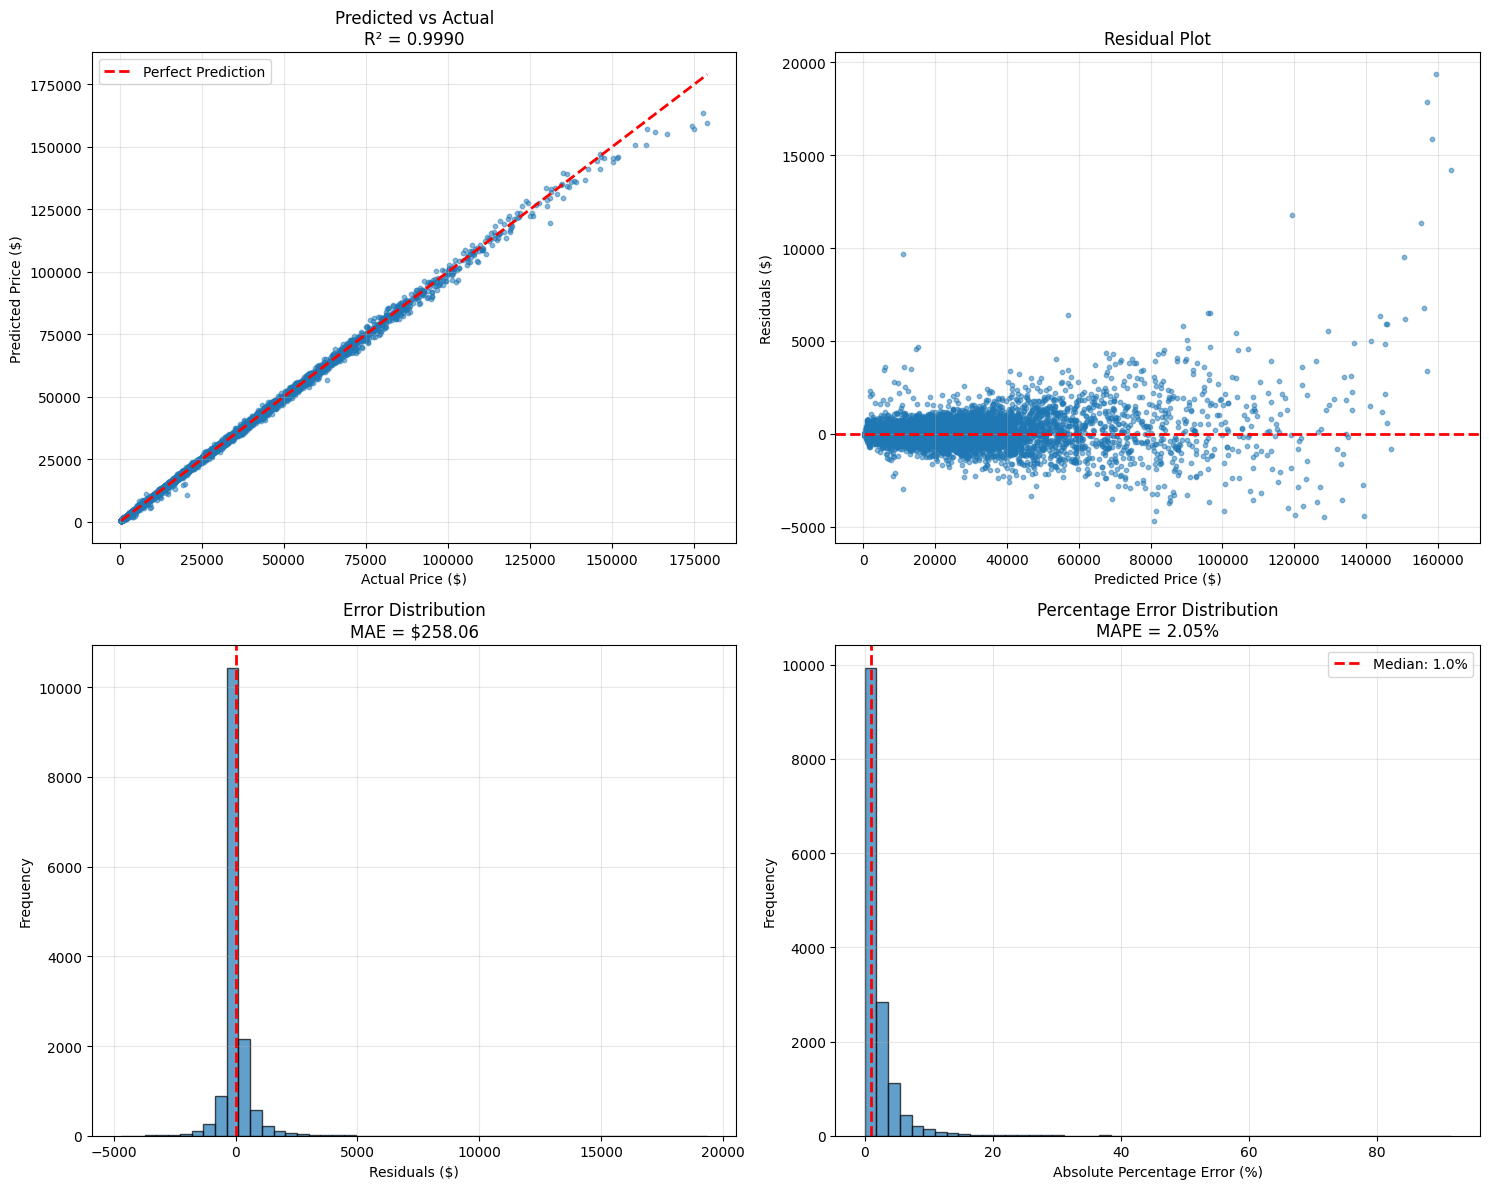


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
              feature          mean          std
price_retention_ratio 366975.422177 66376.989920
            age_ratio 186136.838004 70498.306418
 remaining_life_ratio 171199.710291 25741.348373
       remaining_life  91065.464345 70447.359118
       Original_Price  53702.925835   573.826698
   log_original_price  28355.346227   350.085050
       price_per_year   7080.424117   199.903187
    depreciation_rate   4811.791868   215.953544
            Condition   4205.360610    53.239464
    quality_condition   2210.212527   115.532047
          near_expiry   1191.059183    57.710894
        Used_Duration   1030.794673    86.390200
        Build_Quality    865.094343    58.800045
     quality_lifespan    663.618865    63.122721
         Expiry_Years    561.792376    73.514607


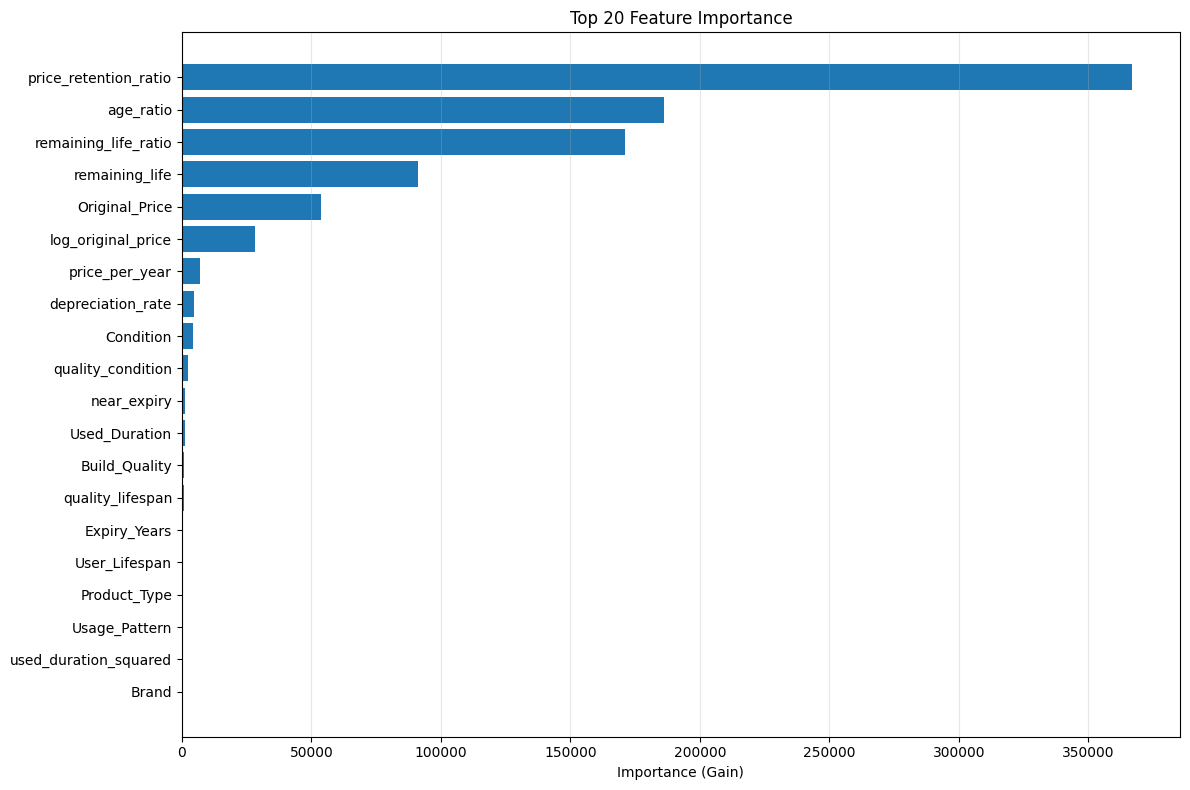


SHAP ANALYSIS (Interpretability)


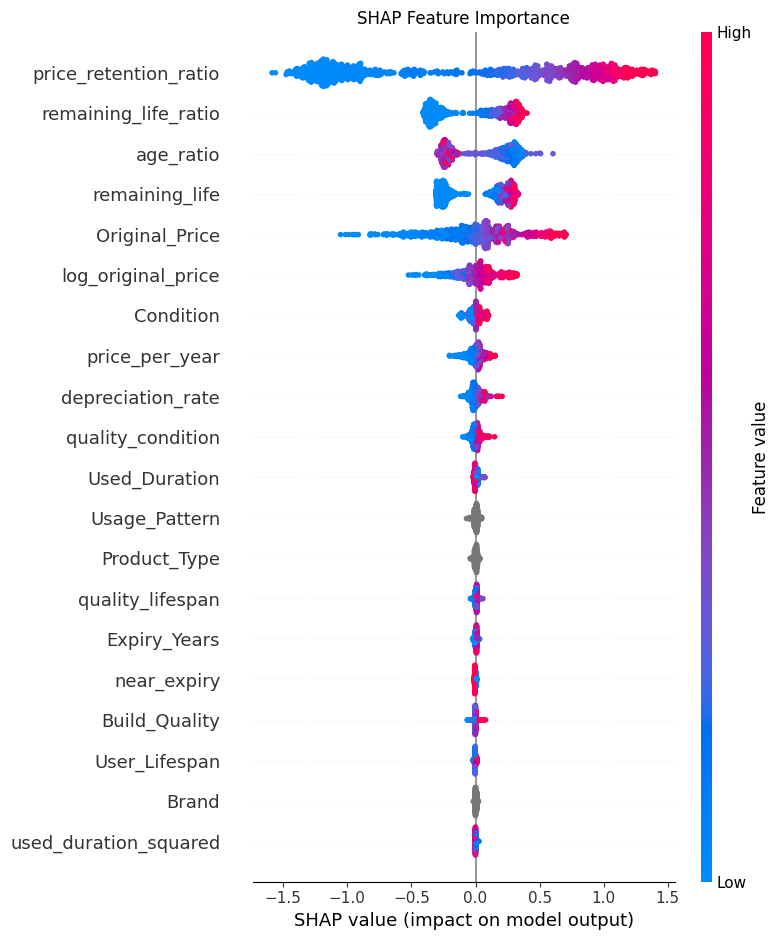


PERFORMANCE BY PRODUCT TYPE

Laptop:
  Count: 1235
  RMSE: $567.45
  MAE:  $235.77
  R²:   0.9991

Smartphone:
  Count: 1234
  RMSE: $518.38
  MAE:  $155.70
  R²:   0.9983

TV:
  Count: 1247
  RMSE: $1,419.66
  MAE:  $693.52
  R²:   0.9980

DSLR Camera:
  Count: 1272
  RMSE: $1,151.96
  MAE:  $543.07
  R²:   0.9988

Electric Scooter:
  Count: 1242
  RMSE: $755.26
  MAE:  $371.45
  R²:   0.9992

Air Conditioner:
  Count: 1267
  RMSE: $319.39
  MAE:  $216.68
  R²:   0.9991

Washing Machine:
  Count: 1237
  RMSE: $270.35
  MAE:  $182.13
  R²:   0.9992

Tablet:
  Count: 1297
  RMSE: $298.06
  MAE:  $126.96
  R²:   0.9991

Microwave:
  Count: 1280
  RMSE: $181.27
  MAE:  $98.80
  R²:   0.9985

Smartwatch:
  Count: 1252
  RMSE: $180.57
  MAE:  $70.05
  R²:   0.9987

Gaming Console:
  Count: 1209
  RMSE: $342.65
  MAE:  $161.93
  R²:   0.9992

Refrigerator:
  Count: 1228
  RMSE: $382.12
  MAE:  $241.22
  R²:   0.9992

SAVING MODELS
Saved: lgb_model_fold_0.txt
Saved: lgb_model_fold_1.txt
Save

In [17]:
# ============================================================================
# 1. LOAD AND EXPLORE DATA
# ============================================================================

# Load dataset
df = pd.read_csv(f"{path}/expiry_price_data.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# ============================================================================
# 2. FEATURE ENGINEERING
# ============================================================================

def create_features(df):
    """Create engineered features"""
    df = df.copy()

    # Age and lifetime ratios
    df['age_ratio'] = df['Used_Duration'] / (df['User_Lifespan'] + 1e-9)
    df['remaining_life'] = (df['User_Lifespan'] - df['Used_Duration']).clip(lower=0)
    df['remaining_life_ratio'] = df['remaining_life'] / (df['User_Lifespan'] + 1e-9)

    # Price-based features
    df['price_per_year'] = df['Original_Price'] / (df['Expiry_Years'] + 1e-9)
    df['depreciation_rate'] = (df['Original_Price'] - df['Current_Price']) / (df['Used_Duration'] + 1e-9)
    df['price_retention_ratio'] = df['Current_Price'] / (df['Original_Price'] + 1e-9)

    # Log transforms for skewed features
    df['log_original_price'] = np.log1p(df['Original_Price'])

    # Interaction features
    df['quality_condition'] = df['Build_Quality'] * df['Condition']
    df['quality_lifespan'] = df['Build_Quality'] * df['User_Lifespan']

    # Polynomial features
    df['used_duration_squared'] = df['Used_Duration'] ** 2

    # Is product near end of life?
    df['near_expiry'] = (df['remaining_life'] < 2).astype(int)

    return df

# Apply feature engineering
df = create_features(df)

print("\nFeatures after engineering:")
print(df.columns.tolist())

# ============================================================================
# 3. PREPARE DATA FOR MODELING
# ============================================================================

# Target transformation (log1p for stability)
y = np.log1p(df['Current_Price'])

# Features
feature_cols = [
    # Original features
    'Product_Type', 'Brand', 'Build_Quality', 'User_Lifespan',
    'Usage_Pattern', 'Expiry_Years', 'Condition', 'Original_Price', 'Used_Duration',
    # Engineered features
    'age_ratio', 'remaining_life', 'remaining_life_ratio',
    'price_per_year', 'depreciation_rate', 'price_retention_ratio',
    'log_original_price', 'quality_condition', 'quality_lifespan',
    'used_duration_squared', 'near_expiry'
]

X = df[feature_cols].copy()

# Convert categorical features
categorical_features = ['Product_Type', 'Brand', 'Usage_Pattern']
for col in categorical_features:
    X[col] = X[col].astype('category')

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# ============================================================================
# 4. CREATE STRATIFIED FOLDS
# ============================================================================

n_splits = 5
n_bins = 10

# Create bins for stratification
y_binned = pd.qcut(df['Current_Price'].rank(method='first'), q=n_bins, labels=False, duplicates='drop')

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"\nUsing {n_splits}-fold stratified cross-validation")

# ============================================================================
# 5. OPTUNA HYPERPARAMETER TUNING
# ============================================================================

def objective(trial):
    """Optuna objective function for hyperparameter tuning"""

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 512),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-3, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

    cv_scores = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y_binned)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        lgb_train = lgb.Dataset(
            X_train,
            label=y_train,
            categorical_feature=categorical_features
        )

        lgb_valid = lgb.Dataset(
            X_valid,
            label=y_valid,
            reference=lgb_train,
            categorical_feature=categorical_features
        )

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )

        preds = model.predict(X_valid, num_iteration=model.best_iteration)
        # FIXED: Use np.sqrt instead of squared parameter
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        cv_scores.append(rmse)

    return np.mean(cv_scores)

print("\n" + "="*70)
print("STARTING HYPERPARAMETER OPTIMIZATION")
print("="*70)

# Create Optuna study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

# Optimize
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)
print(f"\nBest RMSE (log scale): {study.best_value:.6f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ============================================================================
# 6. TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================

best_params = study.best_params.copy()
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
})

print("\n" + "="*70)
print("TRAINING FINAL MODEL WITH CROSS-VALIDATION")
print("="*70)

# Store results
oof_predictions = np.zeros(len(X))
models = []
feature_importance_list = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y_binned)):
    print(f"\nTraining fold {fold + 1}/{n_splits}...")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    lgb_train = lgb.Dataset(
        X_train,
        label=y_train,
        categorical_feature=categorical_features
    )

    lgb_valid = lgb.Dataset(
        X_valid,
        label=y_valid,
        reference=lgb_train,
        categorical_feature=categorical_features
    )

    model = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=2000,
        valid_sets=[lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )

    # Predictions
    oof_predictions[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)

    # Store model and feature importance
    models.append(model)
    feature_importance_list.append(
        pd.DataFrame({
            'feature': model.feature_name(),
            'importance': model.feature_importance(importance_type='gain'),
            'fold': fold
        })
    )

    # Fold metrics
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_predictions[valid_idx]))
    print(f"Fold {fold + 1} RMSE (log scale): {fold_rmse:.6f}")

# ============================================================================
# 7. EVALUATE MODEL PERFORMANCE
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Convert predictions back to original scale
y_true_original = np.expm1(y)
y_pred_original = np.expm1(oof_predictions)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
mae = mean_absolute_error(y_true_original, y_pred_original)
r2 = r2_score(y_true_original, y_pred_original)
mape = np.mean(np.abs((y_true_original - y_pred_original) / (y_true_original + 1e-9))) * 100

print(f"\nOverall Performance (Original Scale):")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:   {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")

# Log scale metrics
rmse_log = np.sqrt(mean_squared_error(y, oof_predictions))
mae_log = mean_absolute_error(y, oof_predictions)
r2_log = r2_score(y, oof_predictions)

print(f"\nPerformance (Log Scale):")
print(f"  RMSE: {rmse_log:.6f}")
print(f"  MAE:  {mae_log:.6f}")
print(f"  R²:   {r2_log:.4f}")

# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_true_original, y_pred_original, alpha=0.5, s=10)
axes[0, 0].plot([y_true_original.min(), y_true_original.max()],
                [y_true_original.min(), y_true_original.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title(f'Predicted vs Actual\nR² = {r2:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_true_original - y_pred_original
axes[0, 1].scatter(y_pred_original, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution\nMAE = ${mae:,.2f}')
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentage Error
percentage_errors = np.abs(residuals) / (y_true_original + 1e-9) * 100
axes[1, 1].hist(percentage_errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=np.median(percentage_errors), color='r', linestyle='--',
                   lw=2, label=f'Median: {np.median(percentage_errors):.1f}%')
axes[1, 1].set_xlabel('Absolute Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Percentage Error Distribution\nMAPE = {mape:.2f}%')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 9. FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Aggregate feature importance across folds
feature_importance_df = pd.concat(feature_importance_list)
feature_importance_agg = feature_importance_df.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
feature_importance_agg = feature_importance_agg.sort_values('mean', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_agg.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance_agg.head(top_n)

plt.barh(range(len(top_features)), top_features['mean'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# ============================================================================
# 10. SHAP ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("SHAP ANALYSIS (Interpretability)")
print("="*70)

# Use first fold model for SHAP
explainer = shap.TreeExplainer(models[0])

# Calculate SHAP values for a sample
sample_size = min(1000, len(X))
X_sample = X.iloc[:sample_size]
shap_values = explainer.shap_values(X_sample)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# ============================================================================
# 11. PERFORMANCE BY PRODUCT TYPE
# ============================================================================

print("\n" + "="*70)
print("PERFORMANCE BY PRODUCT TYPE")
print("="*70)

df_results = pd.DataFrame({
    'Product_Type': df['Product_Type'],
    'Actual': y_true_original,
    'Predicted': y_pred_original
})

for product_type in df['Product_Type'].unique():
    mask = df_results['Product_Type'] == product_type
    subset = df_results[mask]

    if len(subset) > 0:
        rmse_product = np.sqrt(mean_squared_error(subset['Actual'], subset['Predicted']))
        mae_product = mean_absolute_error(subset['Actual'], subset['Predicted'])
        r2_product = r2_score(subset['Actual'], subset['Predicted'])

        print(f"\n{product_type}:")
        print(f"  Count: {len(subset)}")
        print(f"  RMSE: ${rmse_product:,.2f}")
        print(f"  MAE:  ${mae_product:,.2f}")
        print(f"  R²:   {r2_product:.4f}")

# ============================================================================
# 12. SAVE MODELS
# ============================================================================

import joblib

print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

# Save all fold models
for i, model in enumerate(models):
    model.save_model(f'lgb_model_fold_{i}.txt')
    print(f"Saved: lgb_model_fold_{i}.txt")

# Save feature names and categorical features
model_artifacts = {
    'feature_names': feature_cols,
    'categorical_features': categorical_features,
    'best_params': best_params
}

joblib.dump(model_artifacts, 'model_artifacts.pkl')
print("Saved: model_artifacts.pkl")

print("\nAll models saved successfully!")

# ============================================================================
# 13. PREDICTION FUNCTION
# ============================================================================

def predict_price(input_data, models):
    """
    Predict e-waste price using ensemble of models

    Args:
        input_data: DataFrame with same features as training
        models: List of trained LightGBM models

    Returns:
        Predicted price in original scale
    """
    # Apply feature engineering
    input_data = create_features(input_data)

    # Select features
    X_input = input_data[feature_cols].copy()

    # Convert categorical features
    for col in categorical_features:
        X_input[col] = X_input[col].astype('category')

    # Predict with each model and average
    predictions_log = np.zeros((len(X_input), len(models)))
    for i, model in enumerate(models):
        predictions_log[:, i] = model.predict(X_input, num_iteration=model.best_iteration)

    # Average predictions and convert back to original scale
    predictions = np.expm1(predictions_log.mean(axis=1))

    return predictions

print("\n" + "="*70)
print("PREDICTION FUNCTION READY")
print("="*70)
print("\nExample usage:")
print("predictions = predict_price(new_data_df, models)")

# ============================================================================
# 14. EXAMPLE PREDICTION
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE PREDICTION")
print("="*70)

# Create sample input
sample_input = pd.DataFrame({
    'Product_Type': ['Laptop'],
    'Brand': ['Apple'],
    'Build_Quality': [4],
    'User_Lifespan': [7.0],
    'Usage_Pattern': ['Moderate'],
    'Expiry_Years': [8.0],
    'Condition': [4],
    'Original_Price': [100000],
    'Used_Duration': [2],
    'Current_Price': [0]  # This will be ignored
})

predicted_price = predict_price(sample_input, models)[0]

print("\nSample Input:")
print(sample_input[['Product_Type', 'Brand', 'Build_Quality', 'Condition',
                     'Original_Price', 'Used_Duration']].to_string(index=False))
print(f"\nPredicted E-Waste Price: ${predicted_price:,.2f}")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)

In [18]:
# ============================================================================
# 14. EXAMPLE PREDICTION
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE PREDICTION")
print("="*70)

# Create sample input
sample_input = pd.DataFrame({
    'Product_Type': ['Laptop'],
    'Brand': ['Apple'],
    'Build_Quality': [4],
    'User_Lifespan': [7.0],
    'Usage_Pattern': ['Moderate'],
    'Expiry_Years': [8.0],
    'Condition': [4],
    'Original_Price': [100000],
    'Used_Duration': [2],
    'Current_Price': [0]  # This will be ignored
})

predicted_price = predict_price(sample_input, models)[0]

print("\nSample Input:")
print(sample_input[['Product_Type', 'Brand', 'Build_Quality', 'Condition',
                     'Original_Price', 'Used_Duration']].to_string(index=False))
print(f"\nPredicted E-Waste Price: ৳{predicted_price:,.2f}")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)


EXAMPLE PREDICTION

Sample Input:
Product_Type Brand  Build_Quality  Condition  Original_Price  Used_Duration
      Laptop Apple              4          4          100000              2

Predicted E-Waste Price: ৳3,296.82

PIPELINE COMPLETE!
